<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [ ]:
!nvidia-smi

Sun Sep  4 14:39:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [ ]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [ ]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np
from shutil import move
from os.path import join
import os
from google.colab import files

Download the dataset from a remote repository.

In [ ]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

 99% 2.16G/2.18G [00:15<00:00, 164MB/s]
100% 2.18G/2.18G [00:15<00:00, 147MB/s]


In [ ]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
TARGET_SIZE = (160, 160)
EPOCHS = 45
EXPERIMENT_SIZE = 10000
NO_OF_FOLDS = 5

In [ ]:
os.makedirs(os.path.join(os.environ["data_source"], 'train/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'train/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/faces'))

In [ ]:
tmp_comics_dir = './Face_Comics_data/comics'
tmp_faces_dir = './Face_Comics_data/faces'
comics_test_dir = './Face_Comics_data/test/comics'
faces_test_dir = './Face_Comics_data/test/faces'
comics_validation_dir = './Face_Comics_data/validation/comics'
faces_validation_dir = './Face_Comics_data/validation/faces'
comics_train_dir = './Face_Comics_data/train/comics'
faces_train_dir = './Face_Comics_data/train/faces'
train_dir = './Face_Comics_data/train'
validation_dir = './Face_Comics_data/validation'
test_dir = './Face_Comics_data/test'

In [ ]:
from shutil import copyfile

#TEST - TRAINING SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_train_dir, i))
      c += 1
    else:
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_test_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      try:
        move(os.path.join(tmp_faces_dir, i), os.path.join(faces_train_dir, i))
        c += 1
      except:
        c+= 1
        next
    else:
      move(os.path.join(tmp_faces_dir, i), os.path.join(faces_test_dir, i))
      c += 1

TRAIN_SIZE = len(os.listdir(comics_train_dir))

#TRAINING - VALIDATION SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/train/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/train/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(comics_train_dir, i), os.path.join(comics_validation_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(faces_train_dir, i), os.path.join(faces_validation_dir, i))
      c += 1

print('Total training images :', len(os.listdir(comics_train_dir)) + len(os.listdir(faces_train_dir)))
print('Total validation images :', len(os.listdir(comics_validation_dir)) + len(os.listdir(faces_validation_dir)))
print('Total test images :', len(os.listdir(comics_test_dir)) + len(os.listdir(faces_test_dir)))

Total training images : 9800
Total validation images : 4200
Total test images : 6000


Define data augmentation functions to be implemented in the analysis.

In [ ]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

Define the CNN model, the Training and the Validation dataset. 

In [ ]:
def get_compiled_model(i):
  if i == 1:
    ###Create CNN (NORMAL MODEL)
    ##Initialize the CNN
    model_1 = tf.keras.models.Sequential()
          
    model_1.add(tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_1.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_1.add(tf.keras.layers.Flatten())
    #Full Connection
    model_1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_1.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])
    return model_1

  elif i == 2:
    ###Create CNN (DROPOUT MODEL)
    ##Initialize the CNN
    model_2 = tf.keras.models.Sequential()
        
    model_2.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_2.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_2.add(tf.keras.layers.Flatten())
        #Full Connection
    model_2.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #DROPOUTS ok(0.1)
    model_2.add(tf.keras.layers.Dropout(0.1))
    #Output Layer
    model_2.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_2

  elif i == 3:
    ###Create CNN (L1 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_3 = tf.keras.models.Sequential()
        
    model_3.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_3.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_3.add(tf.keras.layers.Flatten())
    #Full Connection
    model_3.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_3.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
    ###Training CNN
    ##Compiling the CNN
    model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_3

  elif i == 4:
    ###Create CNN (L2 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_4 = tf.keras.models.Sequential()
        
    model_4.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))
    
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_4.add(tf.keras.layers.Flatten())
    #Full Connection
    model_4.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_4.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_4

def get_dataset():
    BUFFER_SIZE = 10000
    IMG_SIZE = (350, 350)
    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    #data_dir= "./Face_Comics_data"

    #file_count = sum(len(files) for _, _, files in os.walk(data_dir)) 
    #print(file_count)

    tf.random.set_seed(123456)

    #os.listdir(data_dir)

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    #val_batches = tf.data.experimental.cardinality(validation_dataset)
    #test_dataset = validation_dataset.take(val_batches // 5)
    #validation_dataset = validation_dataset.skip(val_batches // 5)
    #print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
    #print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    #print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )

def AIC(n_examples, mse, n_model_parameters):
  AIC_SCORE = (n_examples * np.log(mse) ) + (2*n_model_parameters)
  return AIC_SCORE


Create a Mirrored strategy in order to distribute computation with Tensorflow engine.

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


Number of devices: 1


Found 9800 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.
Found 6000 files belonging to 2 classes.
****************************** Model n.1 ******************************
Epoch 1/45
154/154 [==============================] - 88s 440ms/step - loss: 0.6337 - accuracy: 0.6020 - mse: 0.2248 - val_loss: 0.3370 - val_accuracy: 0.7526 - val_mse: 0.1102
Epoch 2/45
154/154 [==============================] - 66s 415ms/step - loss: 0.4888 - accuracy: 0.7338 - mse: 0.1661 - val_loss: 0.2756 - val_accuracy: 0.9181 - val_mse: 0.0853
Epoch 3/45
154/154 [==============================] - 67s 422ms/step - loss: 0.3646 - accuracy: 0.8442 - mse: 0.1181 - val_loss: 0.2010 - val_accuracy: 0.9429 - val_mse: 0.0584
Epoch 4/45
154/154 [==============================] - 67s 420ms/step - loss: 0.3620 - accuracy: 0.8472 - mse: 0.1121 - val_loss: 0.1847 - val_accuracy: 0.9698 - val_mse: 0.0447
Epoch 5/45
154/154 [==============================] - 66s 414ms/step - loss: 0.2271 - accuracy: 0

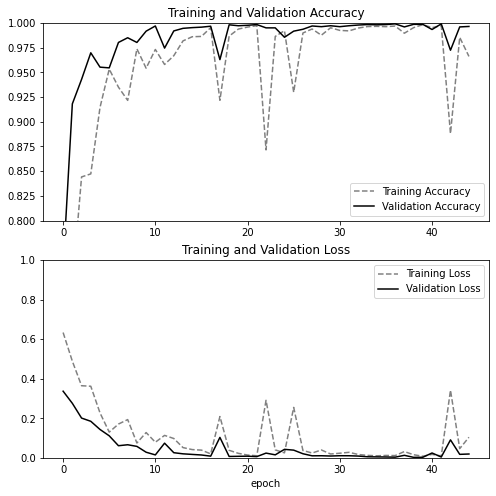

****************************** Model n.2 ******************************
Epoch 1/45
154/154 [==============================] - 72s 428ms/step - loss: 0.6746 - accuracy: 0.6035 - mse: 0.2282 - val_loss: 0.4320 - val_accuracy: 0.7902 - val_mse: 0.1424
Epoch 2/45
154/154 [==============================] - 67s 420ms/step - loss: 0.3410 - accuracy: 0.8398 - mse: 0.1091 - val_loss: 0.0696 - val_accuracy: 0.9888 - val_mse: 0.0136
Epoch 3/45
154/154 [==============================] - 66s 413ms/step - loss: 0.3333 - accuracy: 0.8571 - mse: 0.1028 - val_loss: 0.2728 - val_accuracy: 0.9393 - val_mse: 0.0792
Epoch 4/45
154/154 [==============================] - 67s 420ms/step - loss: 0.2425 - accuracy: 0.9011 - mse: 0.0737 - val_loss: 0.1260 - val_accuracy: 0.9381 - val_mse: 0.0406
Epoch 5/45
154/154 [==============================] - 67s 420ms/step - loss: 0.1408 - accuracy: 0.9445 - mse: 0.0412 - val_loss: 0.1695 - val_accuracy: 0.9331 - val_mse: 0.0501
Epoch 6/45
154/154 [=======================

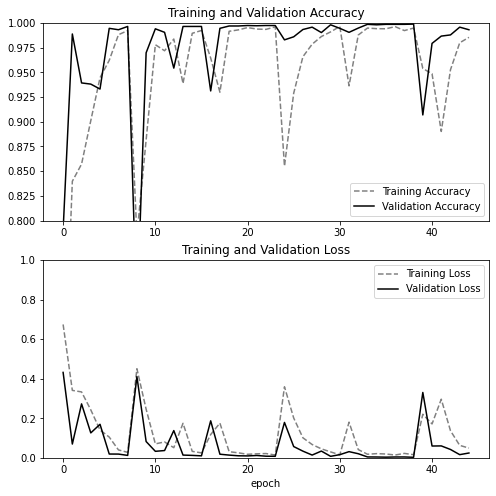

****************************** Model n.3 ******************************
Epoch 1/45
(5, 5, 3, 32)
Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(4,), dtype=int32)
154/154 [==============================] - 71s 423ms/step - loss: 9.4230 - accuracy: 0.7331 - mse: 0.1941 - val_loss: 7.0269 - val_accuracy: 0.7848 - val_mse: 0.1482
Epoch 2/45
154/154 [==============================] - 66s 415ms/step - loss: 6.2900 - accuracy: 0.8161 - mse: 0.1314 - val_loss: 5.6716 - val_accuracy: 0.7945 - val_mse: 0.1438
Epoch 3/45
154/154 [==============================] - 67s 420ms/step - loss: 5.1005 - accuracy: 0.8131 - mse: 0.1307 - val_loss: 4.4051 - val_accuracy: 0.9005 - val_mse: 0.0734
Epoch 4/45
154/154 [==============================] - 67s 422ms/step - loss: 4.0672 - accuracy: 0.8598 - mse: 0.1036 - val_loss: 3.5818 - val_accuracy: 0.8812 - val_mse: 0.0837
Epoch 5/45
154/154 [==============================] - 66s 415ms/step - loss: 3.3075 - accuracy: 0.8669 - mse: 0.1014 -

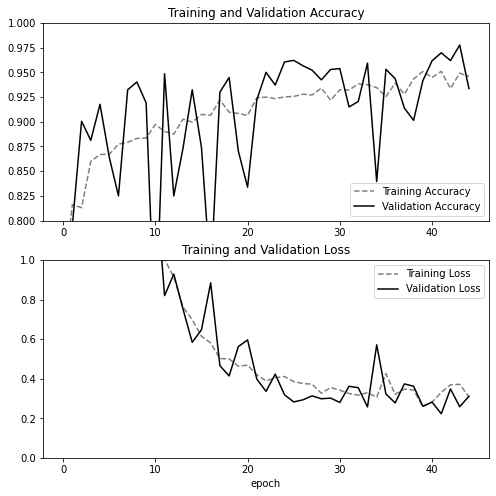

****************************** Model n.4 ******************************
Epoch 1/45
154/154 [==============================] - 73s 428ms/step - loss: 2.5827 - accuracy: 0.6578 - mse: 0.2303 - val_loss: 0.9158 - val_accuracy: 0.8417 - val_mse: 0.1141
Epoch 2/45
154/154 [==============================] - 67s 424ms/step - loss: 0.9652 - accuracy: 0.8057 - mse: 0.1395 - val_loss: 0.8296 - val_accuracy: 0.8617 - val_mse: 0.1016
Epoch 3/45
154/154 [==============================] - 66s 418ms/step - loss: 0.8350 - accuracy: 0.8537 - mse: 0.1071 - val_loss: 0.7724 - val_accuracy: 0.8731 - val_mse: 0.0940
Epoch 4/45
154/154 [==============================] - 67s 419ms/step - loss: 0.7720 - accuracy: 0.8707 - mse: 0.0954 - val_loss: 0.7899 - val_accuracy: 0.8443 - val_mse: 0.1109
Epoch 5/45
154/154 [==============================] - 67s 425ms/step - loss: 0.6879 - accuracy: 0.8969 - mse: 0.0778 - val_loss: 0.5686 - val_accuracy: 0.9348 - val_mse: 0.0478
Epoch 6/45
154/154 [=======================

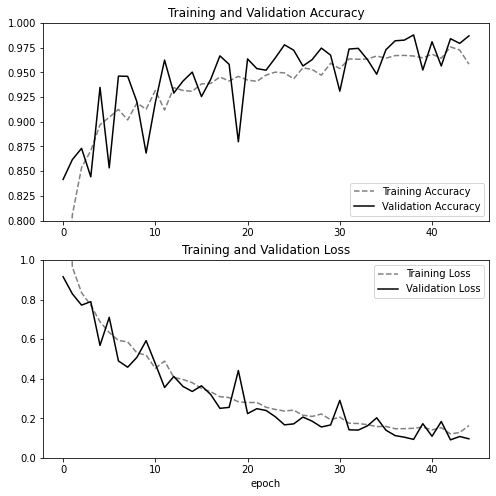

In [ ]:
train_dataset, validation_dataset, test_dataset = get_dataset()

#Compute number of examples
Example_number = 1400

AIC_list = []
MSE_list = []
Models_parameters_n_list = []
for n in range(4):
  with strategy.scope():
    model = get_compiled_model(n+1)
    print(f'****************************** Model n.{n+1} ******************************')
    model_fit = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)
    model_fit
    model.summary()

    #Retrieve MSE values for each epoch
    Model_MSE = model_fit.history['mse']
    MSE_list += model_fit.history['mse']

    #Retrieve Parameters numbers for each model
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))

    substring = 'Trainable params'

    c = 0
    for n in stringlist:
        if substring not in n:
          c += 1
        else:
          break

    substring = stringlist[c]  
    Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
    Models_parameters_n_list += [Model_parameters_n]

    #Aikaike Information Creterion (AIC) Computation
    for mse_score in Model_MSE:
      AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
      AIC_list += AIC_SCORE

    #Show training and validation graphs
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss_ = model_fit.history['loss']
    val_loss_ = model_fit.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
    plt.plot(val_acc, label='Validation Accuracy', color = 'black')
    plt.ylim([0.8, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
    plt.plot(val_loss_, label='Validation Loss', color = 'black')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    print('****************************** Test Evaluate ******************************')
    model.evaluate(test_dataset)


Text(0.5, 1.0, 'Training and Validation Accuracy')

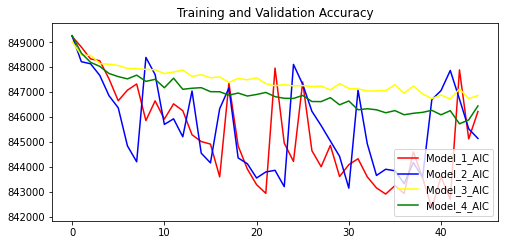

In [ ]:
#Show training and validation graphs
Model_1_AIC = AIC_list[0:EPOCHS]
Model_2_AIC = AIC_list[EPOCHS:EPOCHS*2]
Model_3_AIC = AIC_list[EPOCHS*2:EPOCHS*3]
Model_4_AIC = AIC_list[EPOCHS*3:EPOCHS*4]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC, label='Model_1_AIC', color = 'red')
plt.plot(Model_2_AIC, label='Model_2_AIC', color = 'blue')
plt.plot(Model_3_AIC, label='Model_3_AIC', color = 'yellow')
plt.plot(Model_4_AIC, label='Model_4_AIC', color = 'green')
plt.ylim([min(AIC_list)-500, max(AIC_list)+500])
plt.legend(loc='lower right')
plt.title('Validation AIC')

Create a Strategy scope, and put the compiled model inside it.

In [ ]:
Model_1_AIC_MA = Model_1_AIC
Model_2_AIC_MA = Model_2_AIC
Model_3_AIC_MA = Model_3_AIC
Model_4_AIC_MA = Model_4_AIC

n = 0
for i in Model_1_AIC:
    avg_score_Model_1 = round(sum(Model_1_AIC[:(n+1)])/(n+1))
    avg_score_Model_2 = round(sum(Model_2_AIC[:(n+1)])/(n+1))
    avg_score_Model_3 = round(sum(Model_3_AIC[:(n+1)])/(n+1))
    avg_score_Model_4 = round(sum(Model_4_AIC[:(n+1)])/(n+1))
    Model_1_AIC_MA[n] = avg_score_Model_1
    Model_2_AIC_MA[n] = avg_score_Model_2
    Model_3_AIC_MA[n] = avg_score_Model_3
    Model_4_AIC_MA[n] = avg_score_Model_4
    n = n + 1

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC_MA, label='Model_1_AIC_MA', color = 'red')
plt.plot(Model_2_AIC_MA, label='Model_2_AIC_MA', color = 'blue')
plt.plot(Model_3_AIC_MA, label='Model_3_AIC_MA', color = 'yellow')
plt.plot(Model_4_AIC_MA, label='Model_4_AIC_MA', color = 'green')
plt.ylim([min(AIC_list)-500, max(AIC_list)+500])
plt.legend(loc='lower right')
plt.title('Validation Average AIC')


In [ ]:
d = {
  "Normal (Model 1)": Model_1_AIC_MA[len(Model_1_AIC)-1],
  "Dropout (Model 2)": Model_2_AIC_MA[len(Model_2_AIC)-1],
  "L1 Regularization (Model 3)": Model_3_AIC_MA[len(Model_3_AIC)-1],
  "L2 Regularization (Model 4)": Model_4_AIC_MA[len(Model_4_AIC)-1]
}

best_model = min(d, key=d.get)
print(f'The Best Model is: {best_model}')

Train the model on all available devices.

Test the model on all available devices.

Plot the Train and Validation loss and accuracy graph.